# Filter cells based on QC criteria

In this notebook, we'll retrieve the metadata from .h5 and .arrow files, combine these for each cell, then filter based on the following QC criteria:



## Load packages

hise: The Human Immune System Explorer R SDK package  
dplyr: Dataframe handling functions  
ggplot2: Plotting library

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(dplyr)
quiet_library(ggplot2)

In [2]:
read_uuid_path <- function(uuid) {
    cache_path <- paste0("cache/", uuid)
    if(!dir.exists(cache_path)) {
        res <- cacheFiles(list(uuid))
    }
    file_path <- list.files(
        cache_path,
        full.names = TRUE
    )
    return(file_path)
}
read_csv_uuid <- function(uuid) {
    csv_path <- read_uuid_path(uuid)
    read.csv(csv_path)
}

## Retrieve files from HISE

The metadata from RNA/ADT .h5 files and from ATAC .arrow files was previously assembled across all samples. We'll use the file UUIDs from these previous steps to retrieve both files, which will be stored in `cache/`.

In [3]:
sample_manifest <- read.csv("sample_meta.csv")

In [4]:
rna_adt_uuid <- "28b8a1e9-26ff-4b44-8ac9-389f1f9eb445"
atac_uuid <- "d6fc10e1-2283-4086-ac08-ee7a04256bef"

In [5]:
rna_meta <- read.csv("output/te_rna_adt_cell_metadata.csv")

In [6]:
nrow(rna_meta)

[1] 102710

In [7]:
atac_meta <- read.csv("output/atac_cell_metadata.csv")

In [8]:
nrow(atac_meta)

[1] 99526

## Filter RNA/ADT metadata

We'll use the following criteria to filter cell based on scRNA-seq and ADT quality control metrics:

**scRNA-seq**  

In [9]:
min_genes <- 500  
max_genes <- 4e3  

max_frac_mito_umis <- 0.2

**ADT**  

In [10]:
min_adt_umis <- 1e3  
max_adt_umis <- 1e4

Prior to filtering, let's make a summary table and a few plots to see what we'll exclude with these criteria.

In [11]:
rna_meta <- rna_meta %>%
  mutate(sample.sampleKitGuid = sub("PB([0-9]+)-.+", "KT\\1", pbmc_sample_id)) %>%
  left_join(sample_manifest) %>%
  mutate(frac_mito_umis = n_mito_umis / n_umis)

Joining with `by = join_by(sample.sampleKitGuid)`


In [12]:
qc_filter_summary <- rna_meta %>%
  reframe(
      criteria = c(paste("n_genes >", min_genes), 
                   paste("n_genes <", max_genes),
                   paste("frac_mito_umis <", max_frac_mito_umis),
                   paste("adt_umis >", min_adt_umis),
                   paste("adt_umis <", max_adt_umis),
                   "all"),
      n_pass = c(sum(n_genes > min_genes), 
                 sum(n_genes < max_genes),
                 sum(frac_mito_umis < max_frac_mito_umis),
                 sum(adt_umis > min_adt_umis),
                 sum(adt_umis < max_adt_umis),
                 sum(n_genes > min_genes & 
                     n_genes < max_genes & 
                     frac_mito_umis < max_frac_mito_umis & 
                     adt_umis > min_adt_umis & 
                     adt_umis < max_adt_umis)),
      n_fail = c(sum(n_genes <= min_genes), 
                 sum(n_genes >= max_genes),
                 sum(frac_mito_umis >= max_frac_mito_umis),
                 sum(adt_umis <= min_adt_umis),
                 sum(adt_umis >= max_adt_umis),
                 sum(!(n_genes > min_genes & 
                     n_genes < max_genes & 
                     frac_mito_umis < max_frac_mito_umis & 
                     adt_umis > min_adt_umis & 
                     adt_umis < max_adt_umis))),
      perc_fail = round(n_fail / n() * 100, 2)
  )

In [13]:
qc_filter_summary

criteria,n_pass,n_fail,perc_fail
<chr>,<int>,<int>,<dbl>
n_genes > 500,101518,1192,1.16
n_genes < 4000,102696,14,0.01
frac_mito_umis < 0.2,100497,2213,2.15
adt_umis > 1000,101701,1009,0.98
adt_umis < 10000,102661,49,0.05
all,99435,3275,3.19


### N Genes per sample

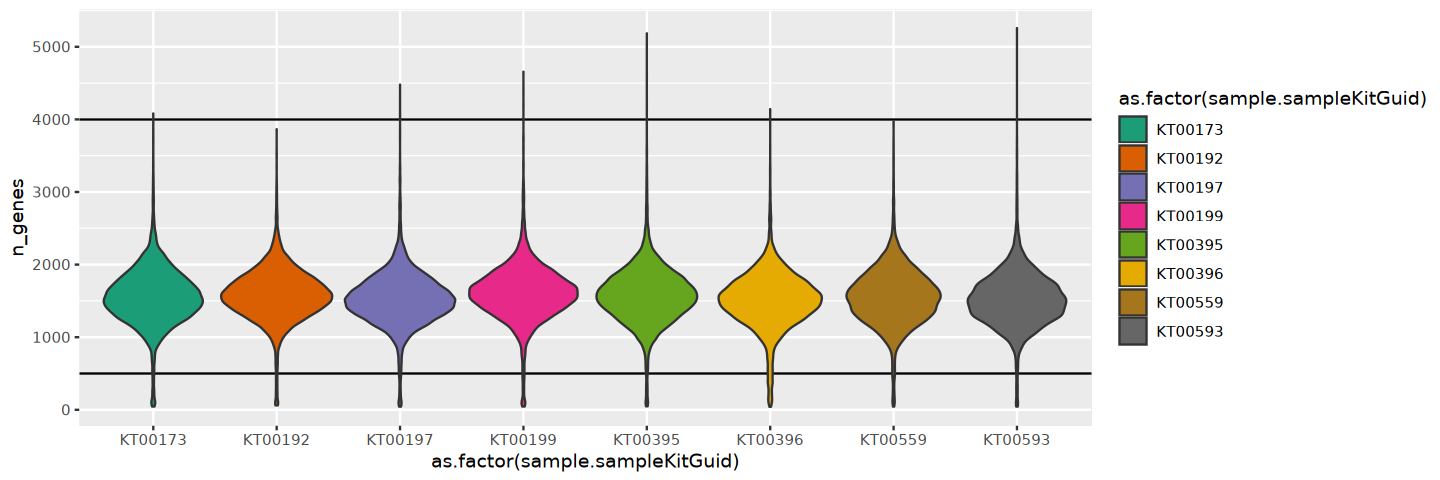

In [14]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_genes, max_genes))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(sample.sampleKitGuid),
          y = n_genes,
          fill = as.factor(sample.sampleKitGuid))
  ) +
  scale_fill_brewer(type = "qual", palette = 2)

### Fraction Mitochondrial UMIs per sample

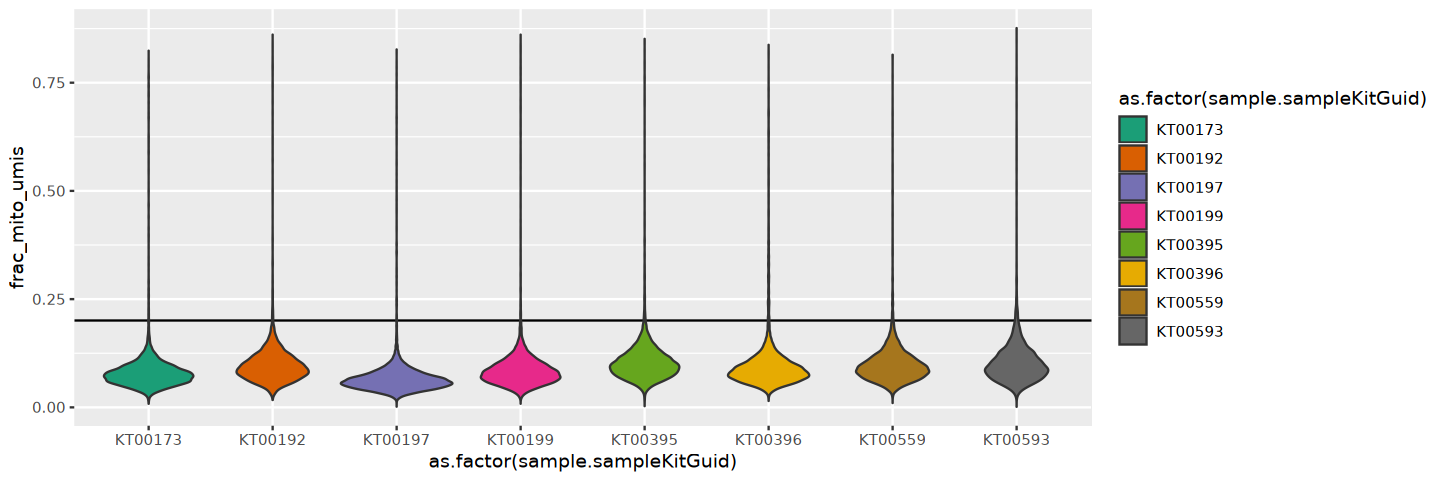

In [15]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(max_frac_mito_umis))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(sample.sampleKitGuid),
          y = frac_mito_umis,
          fill = as.factor(sample.sampleKitGuid))
  ) +
  scale_fill_brewer(type = "qual", palette = 2)

### ADT UMIs per sample

Warning message:
“Removed 17 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


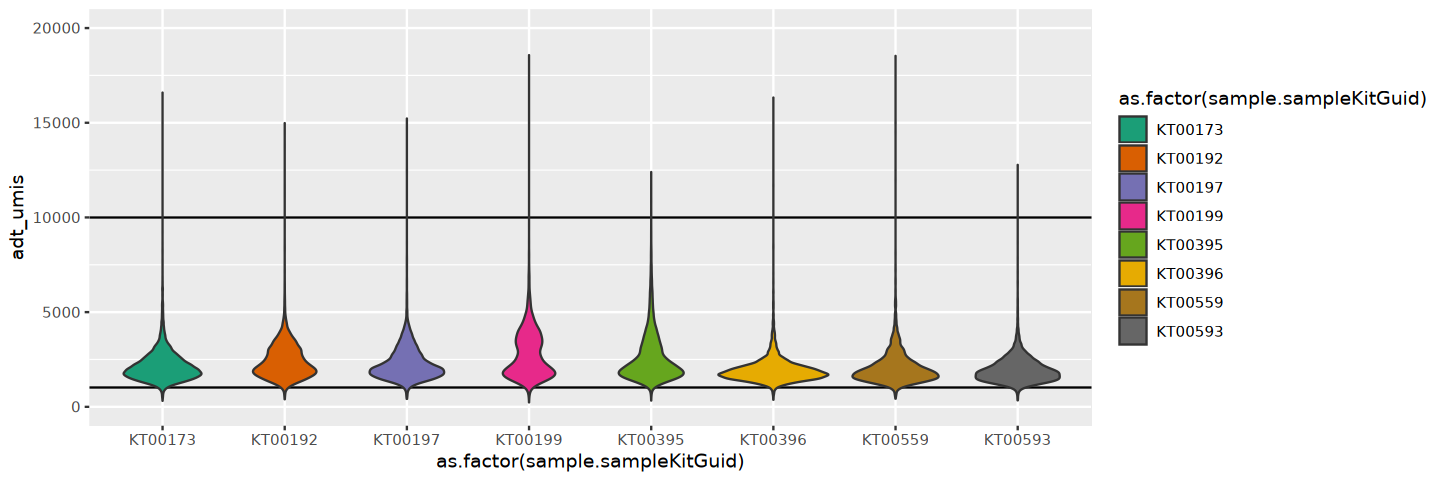

In [16]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_adt_umis, max_adt_umis))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(sample.sampleKitGuid),
          y = adt_umis,
          fill = as.factor(sample.sampleKitGuid))
  ) +
  scale_y_continuous(limits = c(1, 2e4)) +
  scale_fill_brewer(type = "qual", palette = 2)

### Filter RNA criteria

Now, we'll filter to remove cells that fail these metrics

In [17]:
filtered_rna_meta <- rna_meta %>%
  filter(
      n_genes > min_genes,
      n_genes < max_genes,
      frac_mito_umis < max_frac_mito_umis,
      adt_umis > min_adt_umis,
      adt_umis < max_adt_umis
  )
nrow(filtered_rna_meta)

[1] 99435

In [18]:
filtered_rna_meta %>%
  group_by(cohort.cohortGuid, sample.sampleKitGuid) %>%
  summarise(n_cells = n())

`summarise()` has grouped output by 'cohort.cohortGuid'. You can override using
the `.groups` argument.


cohort.cohortGuid,sample.sampleKitGuid,n_cells
<chr>,<chr>,<int>
BR2,KT00395,17319
BR2,KT00396,10139
BR2,KT00559,9769
BR2,KT00593,11052
UP1,KT00173,12435
UP1,KT00192,13338
UP1,KT00197,13193
UP1,KT00199,12190


## Filter ATAC metadata

Our scATAC-seq pipeline does a good job of pre-filtering the ATAC-seq data. A minimum threshhold of 1,000 unique fragments has already been applied at this stage, so we just need to filter on the high end to remove some possible doublets and cells with abnormally high mitochondrial reads. Note that mitochondrial fragments are computed prior to deduplication of reads, so we use n_fragments as the denominator.

We'll use the following criteria to filter cell based on scATAC-seq quality control metrics:

In [19]:
min_frags <- 1e3
max_frags <- 2e4

max_frac_mito <- 0.1

In [20]:
names(atac_meta)

[1] "Sample"           "TSSEnrichment"    "ReadsInTSS"       "ReadsInPromoter" 
 [5] "ReadsInBlacklist" "PromoterRatio"    "PassQC"           "NucleosomeRatio" 
 [9] "nMultiFrags"      "nMonoFrags"       "nFrags"           "nDiFrags"        
[13] "BlacklistRatio"   "archr_name"

In [21]:
atac_meta <- atac_meta %>%
  mutate(pbmc_sample_id = sub(".+_","",Sample)) %>%
  mutate(sample.sampleKitGuid = sub("PB([0-9]+)-.+", "KT\\1", pbmc_sample_id)) %>%
  left_join(sample_manifest) %>%
## REMOVE AFTER PIPELINE
  mutate(frac_mito = 0,
         n_unique = nFrags)
  #mutate(frac_mito = n_mito / n_fragments)

Joining with `by = join_by(sample.sampleKitGuid)`


In [22]:
atac_meta %>%
  reframe(
      criteria = c(paste("n_unique >", min_frags), 
                   paste("n_unique <", max_frags),
                   paste("frac_mito_frags <", max_frac_mito),
                   "all"),
      n_pass = c(sum(n_unique > min_frags), 
                 sum(n_unique < max_frags),
                 sum(frac_mito < max_frac_mito),
                 sum(n_unique > min_frags & 
                     n_unique < max_frags & 
                     frac_mito < max_frac_mito)),
      n_fail = c(sum(n_unique <= min_frags), 
                 sum(n_unique >= max_frags),
                 sum(frac_mito >= max_frac_mito),
                 sum(!(n_unique > min_frags & 
                     n_unique < max_frags & 
                     frac_mito < max_frac_mito))),
      perc_fail = round(n_fail / n() * 100, 2)
  )

criteria,n_pass,n_fail,perc_fail
<chr>,<int>,<int>,<dbl>
n_unique > 1000,99525,1,0.00
n_unique < 20000,99117,409,0.41
frac_mito_frags < 0.1,99526,0,0.00
all,99116,410,0.41


### Unique fragments

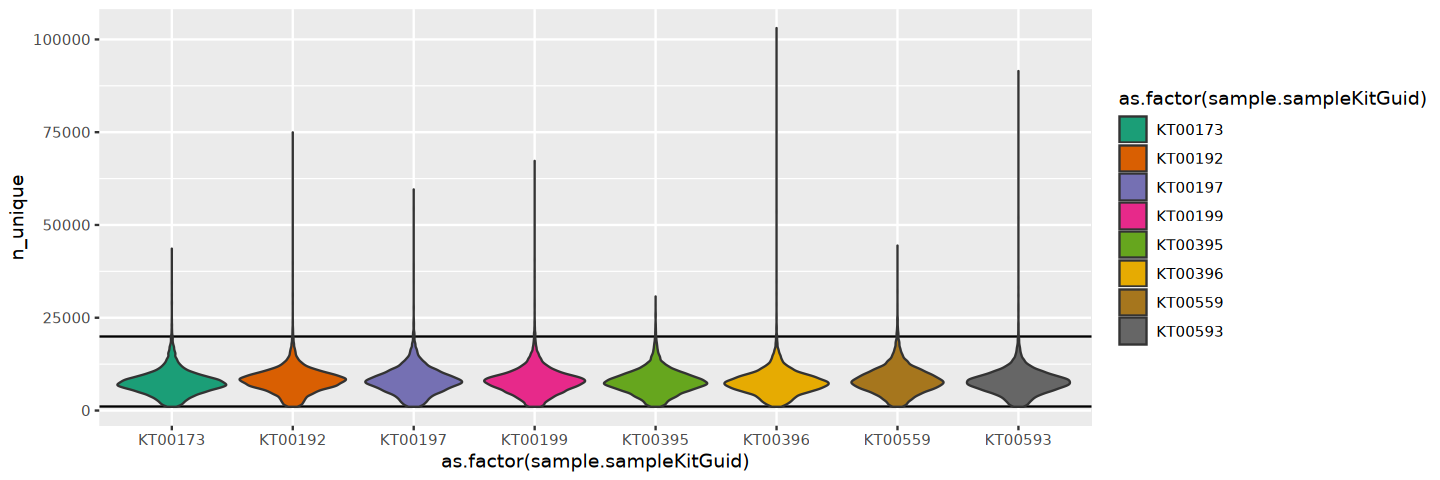

In [23]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_frags, max_frags))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = atac_meta,
      aes(x = as.factor(sample.sampleKitGuid),
          y = n_unique,
          fill = as.factor(sample.sampleKitGuid))
  ) +
  scale_fill_brewer(type = "qual", palette = 2)

### Mitochondrial fragments

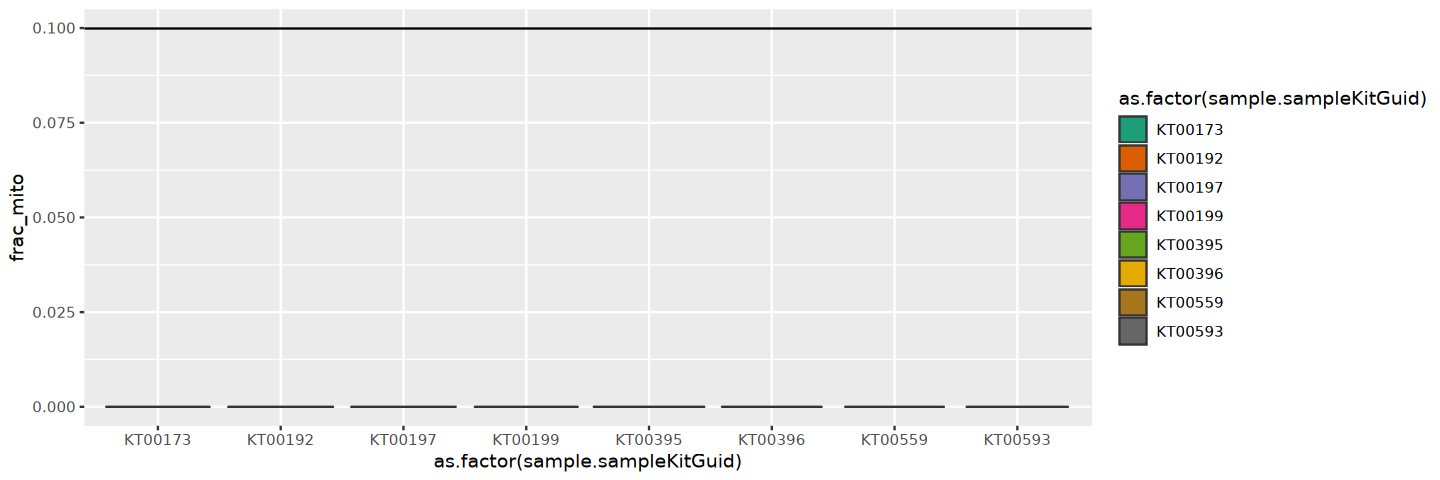

In [24]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(max_frac_mito))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = atac_meta,
      aes(x = as.factor(sample.sampleKitGuid),
          y = frac_mito,
          fill = as.factor(sample.sampleKitGuid))
  ) +
  scale_fill_brewer(type = "qual", palette = 2)

### Filter ATAC criteria

Now, we'll filter to remove cells that fail these metrics

In [25]:
filtered_atac_meta <- atac_meta %>%
  filter(
      n_unique > min_frags,
      n_unique < max_frags,
      frac_mito < max_frac_mito
  )
nrow(filtered_atac_meta)

[1] 99116

In [26]:
filtered_atac_meta %>%
  group_by(cohort.cohortGuid, sample.sampleKitGuid) %>%
  summarise(n_cells = n())

`summarise()` has grouped output by 'cohort.cohortGuid'. You can override using
the `.groups` argument.


cohort.cohortGuid,sample.sampleKitGuid,n_cells
<chr>,<chr>,<int>
BR2,KT00395,17227
BR2,KT00396,10302
BR2,KT00559,9755
BR2,KT00593,11159
UP1,KT00173,12346
UP1,KT00192,13268
UP1,KT00197,13008
UP1,KT00199,12051


## Combine filters across barcodes

Finally, we'll take the filtered metadata across both sets of barcodes and generate a clean, unified set to carry forward for analysis.

In [28]:
final_rna_meta <- filtered_rna_meta %>%
  filter(barcodes %in% filtered_atac_meta$barcodes) %>%
  select(barcodes, adt_umis, batch_id, pool_id, chip_id, well_id, 
         sample.sampleKitGuid, subject.subjectGuid, cohort.cohortGuid,
         n_umis, n_genes,
         #n_reads, n_umis, n_genes, 
         #n_mito_umis, frac_mito_umis,
         original_barcodes, hto_barcode, hto_category)

In [29]:
nrow(final_rna_meta)

[1] 0

In [29]:
names(filtered_atac_meta)

[1] "Sample"            "well_id"           "TSSEnrichment"    
 [4] "tss_frac"          "tss_count"         "singlet"          
 [7] "ReadsInTSS"        "ReadsInPromoter"   "ReadsInBlacklist" 
[10] "PromoterRatio"     "pool_id"           "peaks_frac"       
[13] "peaks_count"       "pbmc_sample_id"    "PassQC"           
[16] "original_barcodes" "NucleosomeRatio"   "nMultiFrags"      
[19] "nMonoFrags"        "nFrags"            "nDiFrags"         
[22] "n_unique"          "n_mito"            "n_fragments"      
[25] "n_duplicate"       "gene_bodies_frac"  "gene_bodies_count"
[28] "DoubletScore"      "DoubletEnrichment" "chip_id"          
[31] "cell_name"         "BlacklistRatio"    "batch_id"         
[34] "barcodes"          "altius_frac"       "altius_count"     
[37] "archr_name"        "lab_label"         "stimulation"      
[40] "treatment"         "timepoint"         "treat_time"       
[43] "frac_mito"

In [30]:
final_atac_meta <- filtered_atac_meta %>%
  filter(barcodes %in% filtered_rna_meta$barcodes) %>%
  select(barcodes, Sample, archr_name,
         n_fragments, n_unique, n_mito, frac_mito)

In [31]:
final_meta <- final_rna_meta %>%
  left_join(final_atac_meta)

Joining with `by = join_by(barcodes)`


## Write output file

Write the metadata as a .csv for later use. We remove `row.names` and set `quote = FALSE` to simplify the outputs and increase compatibility with other tools.

In [32]:
dir.create("output")

In [33]:
write.csv(
    final_meta,
    "output/filtered_tea_cell_metadata.csv",
    row.names = FALSE,
    quote = FALSE
)

## Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference, which we assembled above when files were retrieved (`input_file_uuids`)

In [34]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq QC filtered cell metadata", Sys.Date())

In [40]:
search_id <- ids::adjective_animal()
search_id

[1] "syllabic_nematode"

In [41]:
out_files <- list.files(
    "output",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [42]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = list(rna_adt_uuid, atac_uuid),
    store = "project",
    destination = search_id,
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/repro-vrd-tea-seq/00-cell-filtering/03-R_qc_filtering.ipynb"
[1] "2) /home/jupyter/repro-vrd-tea-seq/repro-vrd-tea-seq-deg-app/jupyter_app.ipynb"
[1] "3) /home/jupyter/repro-vrd-tea-seq/repro-vrd-tea-seq-deg-app/03_UploadVisualization.ipynb"


Please select (1-3)  1


$files
$files[[1]]
[1] "output/filtered_tea_cell_metadata.csv"


$traceId
[1] "e113a699-25cc-4b7b-8f48-b6b2fe6c5751"

In [43]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.0 dplyr_1.1.4   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4       jsonlite_1.8.8     compiler_4.3.2     crayon_1.5.2      
 [5] tidyselect_1.2.0   IRdisplay_1.1      stringr_1.5.1      bitops_1.0-7      
 [9] assertthat_0.2.1   scales_1.3.0       uuid_1.2-0        